In [3]:
library(susieR)
library(data.table)
library(Matrix)
library(XMAP)
library(RhpcBLASctl)
set.seed(1)

In [ ]:
# read GWAS summary statistics
sumstat_EUR <- fread("/home/share/sumstats/format/LDL_allSNPs_UKBNealLab_summary_format.txt")
sumstat_AFR <- fread("/home/share/sumstats/format/LDL_AFR_GLGC_summary_format.txt")

# read LD scores
ldscore <- data.frame()
for (chr in 1:22) {
  ldscore_chr <- fread(paste0("/home/share/mingxuan/UKB_geno_finemap/LDscore_eas_brit_afr_chr", chr, ".txt"))
  ldscore <- rbind(ldscore, ldscore_chr)
  cat("CHR", chr, "\n")
}

# pre-process: remove ambiguous SNPs
idx_amb <- which(ldscore$allele1 == comple(ldscore$allele2))
ldscore <- ldscore[-idx_amb,]


# pre-process: overlap SNPs
snps <- Reduce(intersect, list(ldscore$rsid, sumstat_AFR$SNP, sumstat_EUR$SNP))
sumstat_AFR_ldsc <- sumstat_AFR[match(snps, sumstat_AFR$SNP),]
sumstat_EUR_ldsc <- sumstat_EUR[match(snps, sumstat_EUR$SNP),]
ldscore <- ldscore[match(snps, ldscore$rsid),]


# pre-process: flip alleles
z_afr <- sumstat_AFR_ldsc$beta / sumstat_AFR_ldsc$se
z_eur <- sumstat_EUR_ldsc$Z

idx_flip <- which(sumstat_AFR_ldsc$A1 != ldscore$allele1 & sumstat_AFR_ldsc$A1 != comple(ldscore$allele1))
z_afr[idx_flip] <- -z_afr[idx_flip]

idx_flip <- which(sumstat_EUR_ldsc$A1 != ldscore$allele1 & sumstat_EUR_ldsc$A1 != comple(ldscore$allele1))
z_eur[idx_flip] <- -z_eur[idx_flip]


idx1 <- which(z_afr^2 < 30 & z_eur^2 < 30)
ld_afr_w <- 1 / sapply(ldscore$AFR, function(x) max(x, 1))
ld_eur_w <- 1 / sapply(ldscore$EUR, function(x) max(x, 1))

In [4]:
# bi-variate LDSC: AFR-EUR
# step 1: estimate intercepts
fit_step1 <- estimate_gc(data.frame(Z = z_afr[idx1], N = sumstat_AFR_ldsc$N[idx1]), data.frame(Z = z_eur[idx1], N = sumstat_EUR_ldsc$N[idx1]),
                         ldscore$AFR[idx1], ldscore$EUR[idx1], ldscore$AFR_EUR[idx1],
                         reg_w1 = ld_afr_w[idx1], reg_w2 = ld_eur_w[idx1], reg_wx = sqrt(ld_afr_w[idx1] * ld_eur_w[idx1]),
                         constrain_intercept = F)
# step 1: estimate slopes
fit_step2 <- estimate_gc(data.frame(Z = z_afr, N = sumstat_AFR_ldsc$N), data.frame(Z = z_eur, N = sumstat_EUR_ldsc$N),
                         ldscore$AFR, ldscore$EUR, ldscore$AFR_EUR,
                         reg_w1 = ld_afr_w, reg_w2 = ld_eur_w, reg_wx = sqrt(ld_afr_w * ld_eur_w),
                         constrain_intercept = T, fit_step1$tau1[1], fit_step1$tau2[1], fit_step1$theta[1])


In [5]:
# Assign LDSC estimates to covariance of polygenic effects
OmegaHat <- diag(c(fit_step2$tau1[2], fit_step2$tau2[2])) # AFR EUR
OmegaHat[1, 2] <- fit_step2$theta[2] # co-heritability
OmegaHat[lower.tri(OmegaHat)] <- OmegaHat[upper.tri(OmegaHat)]

c1 <- fit_step2$tau1[1] # AFR
c2 <- fit_step2$tau2[1] # EUR

In [6]:
# read loci information
info <- fread("/home/share/mingxuan/UKB_geno_finemap/chr8_20000001_23000001.info")

# detect allele ambiguous SNPs
idx_amb <- which(info$allele1 == comple(info$allele2))


# overlap SNPs
snps <- Reduce(intersect, list(info$rsid[-idx_amb], sumstat_AFR$SNP, sumstat_EUR$SNP))
sumstat_AFR_i <- sumstat_AFR[match(snps, sumstat_AFR$SNP),]
sumstat_EUR_i <- sumstat_EUR[match(snps, sumstat_EUR$SNP),]

# read LD matrix of AFR
R_afr <- readMM("/home/share/mingxuan/UKB_geno_finemap/chr8_20000001_23000001_afr.mtx.gz")
R_afr <- as.matrix(R_afr + t(R_afr))
idx_afr <- match(snps, info$rsid)
R_afr <- R_afr[idx_afr, idx_afr]

# read LD matrix of EUR
R_brit <- readMM("/home/share/mingxuan/UKB_geno_finemap/chr8_20000001_23000001_brit.mtx.gz")
R_brit <- as.matrix(R_brit + t(R_brit))
idx_brit <- match(snps, info$rsid)
R_brit <- R_brit[idx_brit, idx_brit]

info <- info[match(snps, info$rsid),]

# remove SNPs with small GWAS sample size
idx_outlier_EUR <- which(sumstat_EUR_i$N < 0.7 * median(sumstat_EUR_i$N))
idx_outlier_AFR <- which(sumstat_AFR_i$N < 0.7 * median(sumstat_AFR_i$N))

idx_outlier <- unique(c(idx_outlier_EUR, idx_outlier_AFR))

snps <- snps[-idx_outlier]
sumstat_AFR_i <- sumstat_AFR_i[-idx_outlier,]
sumstat_EUR_i <- sumstat_EUR_i[-idx_outlier,]
info <- info[-idx_outlier,]
R_afr <- R_afr[-idx_outlier, -idx_outlier]
R_brit <- R_brit[-idx_outlier, -idx_outlier]


# flip alleles
z_afr <- sumstat_AFR_i$beta / sumstat_AFR_i$se
z_eur <- sumstat_EUR_i$Z

idx_flip <- which(sumstat_AFR_i$A1 != info$allele1 & sumstat_AFR_i$A1 != comple(info$allele1))
z_afr[idx_flip] <- -z_afr[idx_flip]

idx_flip <- which(sumstat_EUR_i$A1 != info$allele1 & sumstat_EUR_i$A1 != comple(info$allele1))
z_eur[idx_flip] <- -z_eur[idx_flip]


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”


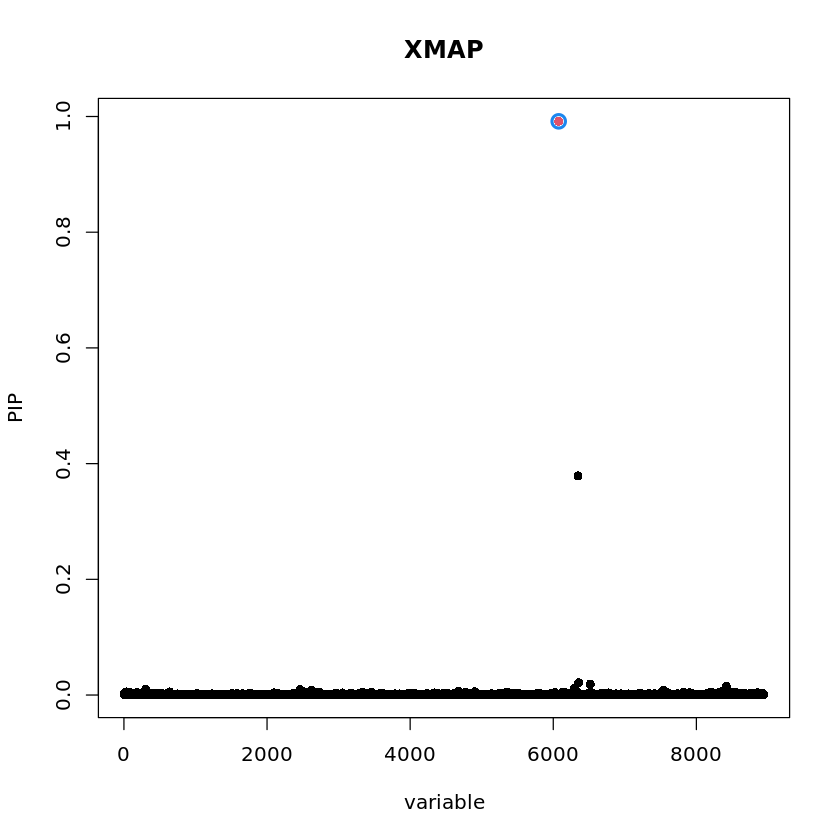

In [7]:
blas_set_num_threads(30)
xmap <- XMAP(simplify2array(list(R_brit, R_afr)), cbind(z_eur, z_afr), c(median(sumstat_EUR_i$N), median(sumstat_AFR_i$N)),
             K = 10, Omega = OmegaHat, Sig_E = c(c1, c2), tol = 1e-6,
             maxIter = 200, estimate_residual_variance = F, estimate_prior_variance = T,
             estimate_background_variance = F)
cs1 <- get_CS(xmap, Xcorr = R_afr, coverage = 0.9, min_abs_corr = 0.1)
cs2 <- get_CS(xmap, Xcorr = R_brit, coverage = 0.9, min_abs_corr = 0.1)
cs_xmap <- cs1$cs[intersect(names(cs1$cs), names(cs2$cs))]
pip_xmap <- get_pip(xmap$gamma)
plot_CS(pip_xmap, cs_xmap, main = "XMAP",b = (info$rsid == "rs900776"))

In [8]:
pip_xmap[info$rsid == "rs900776"]

[1] 0.9916218

HINT: If the in-sample LD matrix is available, we recommend calling susie_rss with the in-sample LD matrix, and setting estimate_residual_variance = TRUE


HINT: For large R or large XtX, consider installing theRfast package for better performance.



[1] "objective:-0.615669456822658"
[1] "objective:-0.615669456822658"


[1] 0.8872784

HINT: If the in-sample LD matrix is available, we recommend calling susie_rss with the in-sample LD matrix, and setting estimate_residual_variance = TRUE


HINT: For large R or large XtX, consider installing theRfast package for better performance.



[1] "objective:4.3924172297648"
[1] "objective:4.44086919972531"
[1] "objective:4.44101973386259"


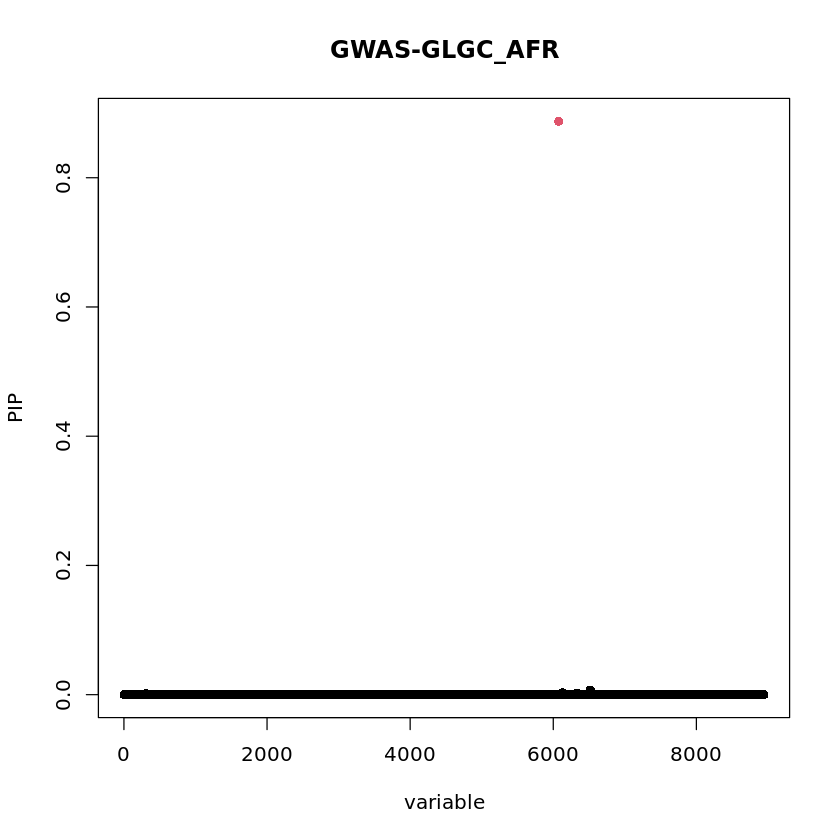

[1] 0.01376944

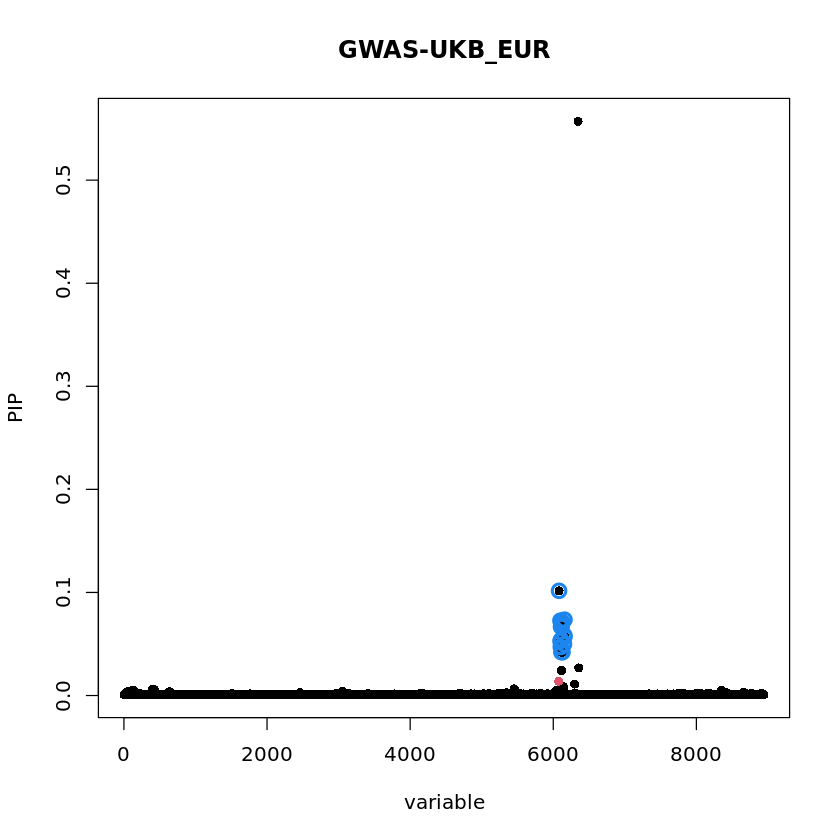

In [9]:
susie_afr <- susie_rss(z_afr, R_afr,
                       L = 10,
                       verbose = TRUE,
                       coverage = 0.9,
                       min_abs_corr = 0.1,
                       check_prior = F)
susie_plot(susie_afr, y = "PIP", b = (info$rsid == "rs900776"), main = "GWAS-GLGC_AFR")
susie_afr$pip[info$rsid == "rs900776"]

susie_eur <- susie_rss(z_eur, R_brit,
                       L = 10,
                       verbose = TRUE,
                       coverage = 0.9,
                       min_abs_corr = 0.1,
                       check_prior = F)
susie_plot(susie_eur, y = "PIP", b = (info$rsid == "rs900776"), main = "GWAS-UKB_EUR")
susie_eur$pip[info$rsid == "rs900776"]
